In [105]:
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

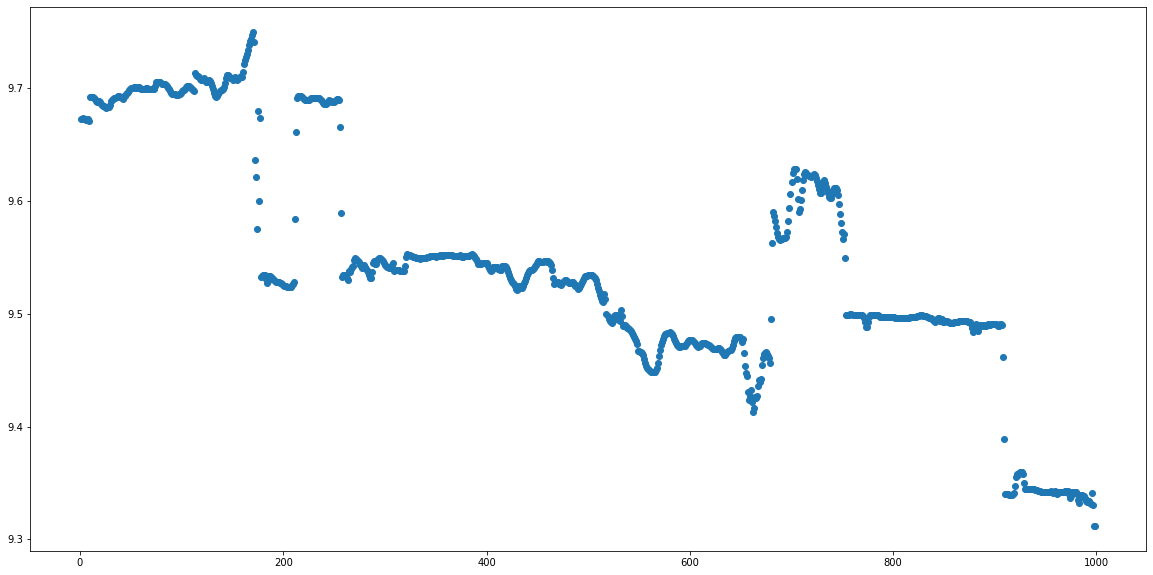

In [37]:
read_file=pd.read_csv(r'D:/calcutta univ internships/final dataset/set-a/csv correct/jumbled.csv')
readfile=read_file.drop('1001',axis=1)
kurt=readfile.kurtosis(axis=0)
kurt
plt.figure(figsize=(20,10))
plt.scatter(range(1,1000),kurt)

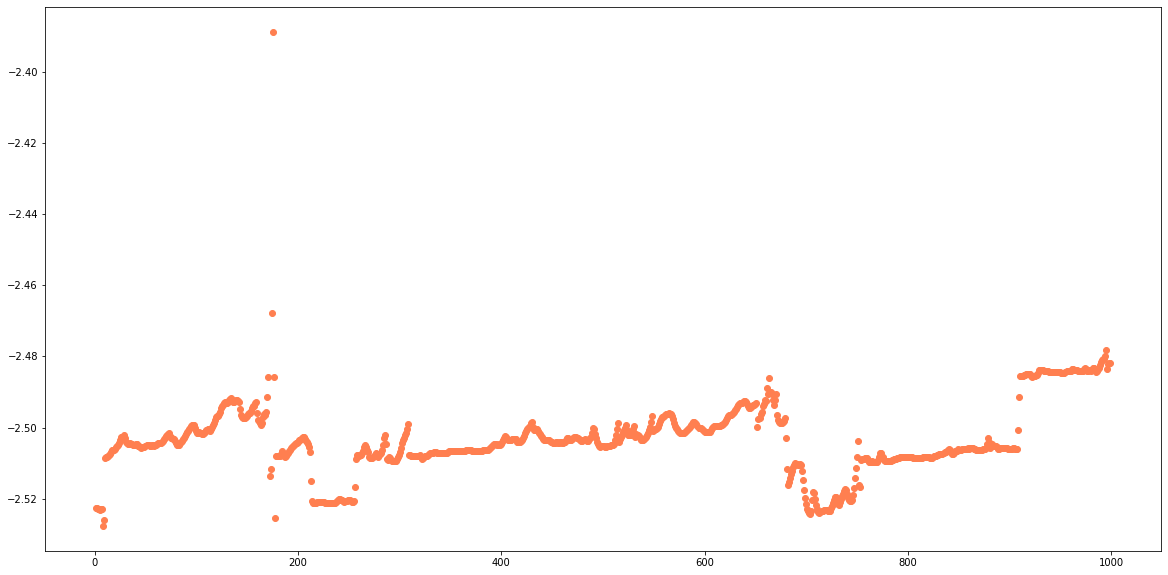

In [40]:
skewv=readfile.skew(axis=0)
skewv
plt.figure(figsize=(20,10))
plt.scatter(range(1,1000),skewv,c='coral')

In [122]:
import numpy as np
import scipy.io

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)


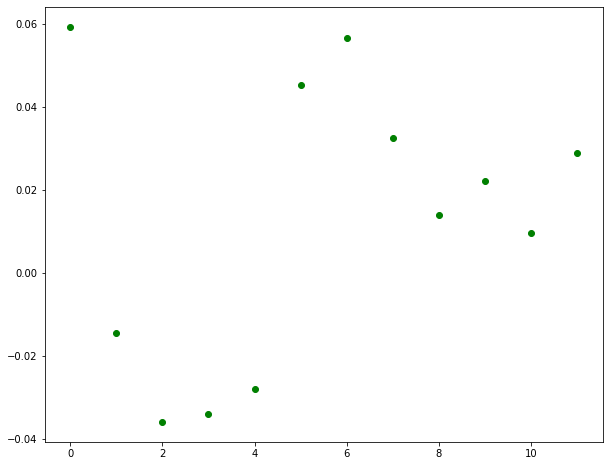

In [126]:
snr=[]
df=pd.read_csv(r'D:/calcutta univ internships/csv correct/1002867.csv')
dffinal=df.drop('1001',axis=1)
for i in range(0,12):
    dfnp=dffinal.iloc[i,:]
    snr.append(signaltonoise(dfnp))

plt.figure(figsize=(10,8))
plt.scatter(range(0,12),snr,c='green')

In [5]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display

import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier
#import entropy as ent

In [1]:
def perm_entropy(list_values, order=3, delay=1, normalize=False):
    val_array=np.array(list_values)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(val_array, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [2]:
def spectral_entropy(list_values, sf, method='fft', nperseg=None, normalize=False,axis=-1):
    val_array = np.asarray(list_values)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(val_array, sf, axis=axis)
    elif method == 'welch':
        _, psd = welch(val_array, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se

In [3]:
def svd_entropy(list_values, order=3, delay=1, normalize=False):
    val_array = np.array(list_values)
    mat = _embed(val_array, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e

In [6]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_LLentropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=np.sum(np.log(np.sqrt(probabilities)))
    return entropy

def detail_entropy(list_values):
    pent=perm_entropy(list_values, normalize=True)
    sent=spectral_entropy(list_values, sf=100, method='welch', normalize=True)
    singent=svd_entropy(list_values, normalize=True)
    return [pent,sent,singent]

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    maximum=np.amax(list_values)
    minimum=np.amin(list_values)
    return [n5, n25, n75, n95, median, mean, std, var, rms,maximum,minimum]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    LE_entropy=calculate_LLentropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    ent=detail_entropy(list_values)
    return [entropy] + crossings + statistics +[LE_entropy]+[ent]

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y



In [8]:
df=pd.read_csv(r'D:/calcutta univ internships/csv correct/1002867.csv')
list_labels=[]
list_features=[]
uci_har_features=[]
val=df['1001']
dffinal=df.drop('1001',axis=1)
for i in range(0,12):
    features=[]
    dfnp=dffinal.iloc[5,:]
    list_coeff = pywt.wavedec(dfnp, 'db4','sym',level=5)
    for coeff in list_coeff:
        features += get_features(coeff)
uci_har_features.append(features)

uci_har_features

NameError: name '_embed' is not defined